In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
import matplotlib.dates as mdates
import ast

### Analisando base de dados

In [34]:
df_geral = pd.read_csv("database/combined_data.csv", sep=';')

In [35]:
produtos_filtrados = ['etanolhidratado', 'gasolinac', 'glp', 'oleodiesel', 'querosenedeaviacao']
df_mestrado = df_geral[(df_geral['product'].isin(produtos_filtrados))]

In [36]:
estatisticas = df_mestrado.groupby('product')['m3'].agg(
    min='min', 
    max='max', 
    media='mean', 
    desvio_padrao='std'
)

print(estatisticas)

                           min           max          media  desvio_padrao
product                                                                   
etanolhidratado       0.000000  1.077622e+06   34304.618694  101520.798647
gasolinac             5.000000  1.035389e+06   87858.227567  134453.059672
glp                 356.226449  3.369416e+05   37292.707901   52741.761740
oleodiesel          478.400000  1.312177e+06  135535.235972  183412.660135
querosenedeaviacao    0.000000  3.711453e+05   15847.039397   39806.093694


In [37]:
produtos_filtrados = ['etanolhidratado', 'gasolinac', 'glp', 'oleodiesel', 'querosenedeaviacao']
df_sp = df_geral[(df_geral['state'] == 'sp') & (df_geral['product'].isin(produtos_filtrados))]

In [38]:
# Dicionário de substituições
substituicoes = {
    'etanolhidratado': 'Etanol Hidratado',
    'gasolinac': 'Gasolina Comum',
    'glp': 'GLP',
    'oleodiesel': 'Óleo Diesel',
    'querosenedeaviacao': 'Querosene de Aviação'
}

# Renomear os valores na coluna 'product'
df_sp['product'] = df_sp['product'].replace(substituicoes)

/tmp/ipykernel_2758138/3068180033.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sp['product'] = df_sp['product'].replace(substituicoes)


datetime64[ns]


/tmp/ipykernel_2758138/3115768410.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sp['timestamp'] = pd.to_datetime(df_sp['timestamp'], errors='coerce')  # Usar 'coerce' para lidar com valores inválidos


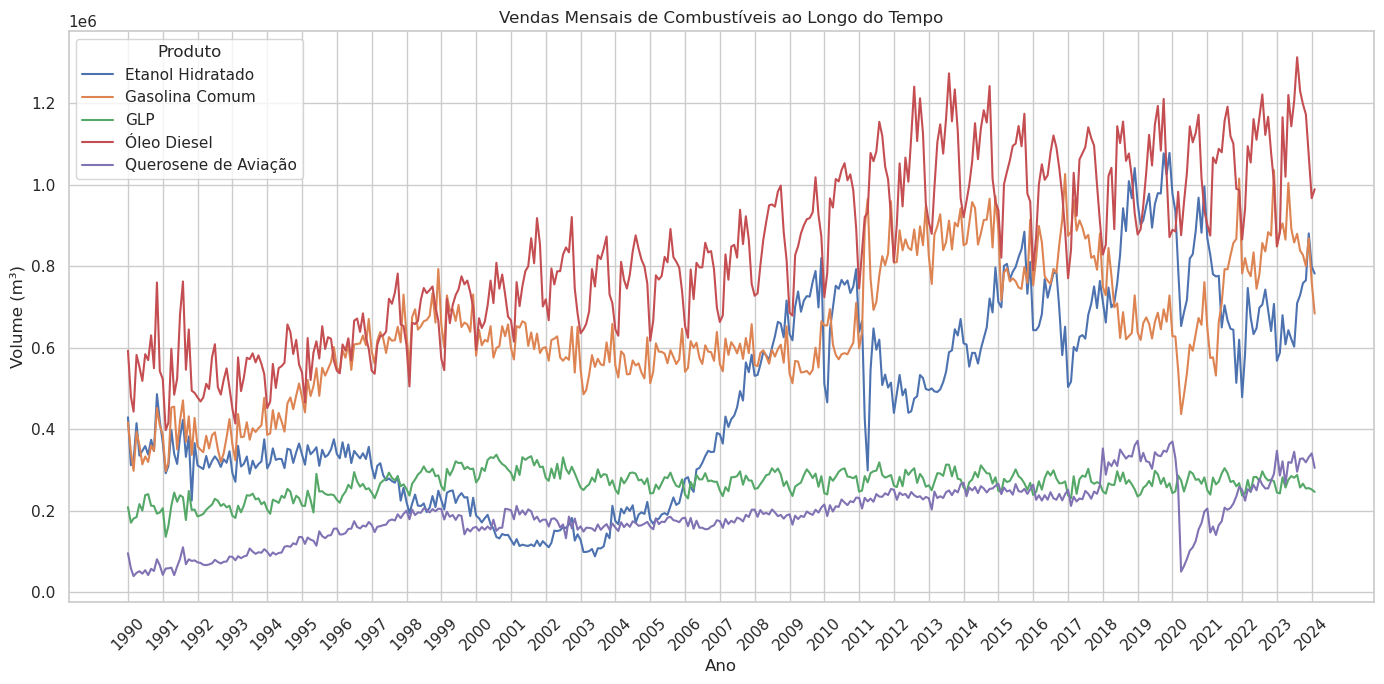

In [39]:
# Converter 'timestamp' para o formato datetime
df_sp['timestamp'] = pd.to_datetime(df_sp['timestamp'], errors='coerce')  # Usar 'coerce' para lidar com valores inválidos

# Verificar se a conversão foi bem-sucedida (opcional, mas útil para depuração)
print(df_sp['timestamp'].dtypes)

# Criar o gráfico de linhas
plt.figure(figsize=(14, 7))
sns.lineplot(data=df_sp, x='timestamp', y='m3', hue='product')

# Ajustar título e rótulos
plt.title('Vendas Mensais de Combustíveis ao Longo do Tempo')
plt.xlabel('Ano')
plt.ylabel('Volume (m³)')

# Extrair anos únicos para o eixo x
unique_years = df_sp['timestamp'].dt.year.dropna().unique()  # Garantir que não há valores nulos
plt.xticks(ticks=[pd.Timestamp(f'{year}-01-01') for year in unique_years], labels=unique_years, rotation=45)

plt.legend(title='Produto')
plt.tight_layout()  # Ajustar layout para evitar sobreposição
plt.show()

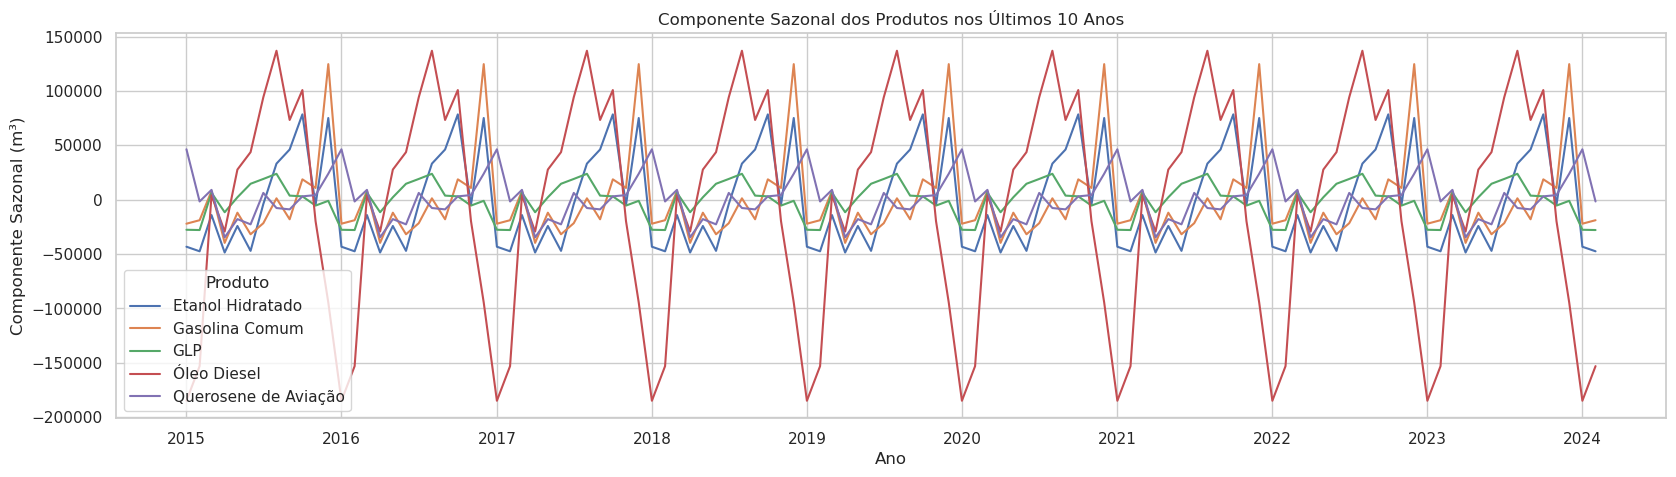

In [40]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Filtrar os últimos 10 anos
df_filtered = df_sp[df_sp['timestamp'] >= pd.Timestamp.now() - pd.DateOffset(years=10)]

# Calcular a sazonalidade usando a decomposição
def decompose_and_plot(product_data):
    result = seasonal_decompose(product_data['m3'], model='additive', period=12)
    seasonal = result.seasonal
    return seasonal

# Criar um DataFrame para os componentes sazonais
seasonal_components = pd.DataFrame()

for product in df_filtered['product'].unique():
    product_data = df_filtered[df_filtered['product'] == product].set_index('timestamp')
    seasonal = decompose_and_plot(product_data)
    seasonal_components[product] = seasonal

# Resetar o índice para plotagem
seasonal_components.reset_index(inplace=True)
seasonal_components.rename(columns={'index': 'timestamp'}, inplace=True)

# Plotar o gráfico
plt.figure(figsize=(20, 5))
sns.lineplot(data=seasonal_components.melt(id_vars='timestamp', var_name='product', value_name='seasonal'),
             x='timestamp', y='seasonal', hue='product')
plt.title('Componente Sazonal dos Produtos nos Últimos 10 Anos')
plt.xlabel('Ano')
plt.ylabel('Componente Sazonal (m³)')
plt.legend(title='Produto')
plt.show()

### Carregando dados

In [41]:

# INFO: ÚLTIMO ANO

df_torch = pd.read_excel("results/lstm_results_pytorch.xlsx") 
df_comp = pd.read_excel("00-RANKING.xlsx")
df_prophet = pd.read_csv("results/Prophet_12_output.csv", header=None)

df_lag_llama = pd.read_csv("results/LagLlama_output.csv", sep=',')
df_lag_llama['PREDICTIONS'] = df_lag_llama['PREDICTIONS'].apply(ast.literal_eval)

df_hibrido = pd.read_excel("results/hybrid_lstm_lagllama.xlsx") 

df_hibrido_time_moe = pd.read_excel("results/hybrid_time_moe_prophet.xlsx") 

df_comp = df_comp.rename(columns={"UF": "STATE"})


# INFO: TIME_MOE

df_time_moe = pd.read_excel("results/results_time_moe.xlsx") 

df_time_moe_fine_tuning_raw_data = pd.read_excel("results/results_time_moe_fine_tuning_raw_data.xlsx") 
df_time_moe_fine_tuning_normalizados = pd.read_excel("results/results_time_moe_fine_tuning_normalizados.xlsx") 
df_time_moe_fine_tuning_direct = pd.read_excel("results/results_time_moe_fine_tuning_direct.xlsx") 
df_time_moe_fine_tuning_multiples = pd.read_excel("results/results_time_moe_fine_tuning_multiples.xlsx") 
df_new_fine_tuning = pd.read_excel("results/results_time_moe_fine_tuning_new.xlsx")  
df_new_fine_tuning_200 = pd.read_excel("results/results_time_moe_fine_tuning_new2.xlsx")  
# Concatenando os DataFrames
df_fine_tuning_time_moe = pd.concat([df_new_fine_tuning, df_new_fine_tuning_200, df_time_moe_fine_tuning_raw_data, df_time_moe_fine_tuning_normalizados, df_time_moe_fine_tuning_direct, df_time_moe_fine_tuning_multiples], ignore_index=True)

# INFO: 5 ANOS

df_n_beats = pd.read_csv("results_5_years/nbeats_results_pytorch_5_years.csv")

df_5anos = pd.read_csv("results_5_years/lstm_results_pytorch_5_years.csv") 

df_time_moe_5_years = pd.read_csv("results_5_years/results_time_moe_5_years.csv") 

df_5anos_all_models = pd.read_csv("12-ALL_5years_BEST.csv") 

df_5anos_all_models = df_5anos_all_models[df_5anos_all_models['MODEL'] != 'LSTM']

df_5anos_all_models = df_5anos_all_models.rename(columns={"UF": "STATE", "MODEL": "TYPE_PREDICTIONS"})

In [42]:
# Calcular a mediana do MAPE por modelo e produto
median_mape_per_product_model = (
    df_fine_tuning_time_moe.groupby(['PRODUCT', 'TYPE_PREDICTIONS'])['MAPE'].median().reset_index()
)

# Ordenar por 'PRODUCT' e pela mediana do MAPE
median_mape_per_product_model = median_mape_per_product_model.sort_values(
    by=['PRODUCT', 'MAPE'], ascending=[True, True]
)

# Selecionar os melhores modelos por produto
top_models_per_product = (
    median_mape_per_product_model.groupby('PRODUCT')
    .head(10)
    .reset_index(drop=True)
)

# Filtrar o DataFrame original para incluir apenas os melhores modelos
df_top_time_moe = df_fine_tuning_time_moe[
    df_fine_tuning_time_moe.set_index(['PRODUCT', 'TYPE_PREDICTIONS']).index.isin(
        top_models_per_product.set_index(['PRODUCT', 'TYPE_PREDICTIONS']).index
    )
]
df_top_time_moe = df_top_time_moe.drop_duplicates()


In [43]:
median_mape_per_product_model

,PRODUCT,TYPE_PREDICTIONS,MAPE
4,etanolhidratado,TimeMoE-200M-FINE-TUNING_10_EPOCHS_RAW_DATA,0.175465
36,etanolhidratado,TimeMoE-200M-FINE-TUNING_normalizados_zero_5e-...,0.175465
66,etanolhidratado,TimeMoE-200M-FINE-TUNING_raw_data_zero_5e-05_c...,0.175465
25,etanolhidratado,TimeMoE-200M-FINE-TUNING_normalizados_zero_0.0...,0.176986
55,etanolhidratado,TimeMoE-200M-FINE-TUNING_raw_data_zero_0.0001_...,0.176986
...,...,...,...
679,querosenedeaviacao,TimeMoE-50M-FINE-TUNING_raw_data_none_0.001_co...,6.210799
678,querosenedeaviacao,TimeMoE-50M-FINE-TUNING_raw_data_none_0.001_co...,6.437777
606,querosenedeaviacao,TimeMoE-200M-FINE-TUNING_raw_data_none_0.001_c...,7.072429
608,querosenedeaviacao,TimeMoE-200M-FINE-TUNING_raw_data_none_0.001_l...,10.012786


In [44]:
# best_results = df_time_moe_5_years.loc[df_time_moe_5_years.groupby(['STATE', 'PRODUCT'])['MAPE'].idxmin()]
# best_results['MODEL'] = "Time-MoE"
# best_results.to_csv("best_results_time_moe.csv", index=False, sep=',')

In [45]:
# import pandas as pd
# import numpy as np
# from sklearn.metrics import mean_absolute_percentage_error as mape
# from metrics_lstm import rmse, pbe, pocid
# import ast

# # Carregar o conjunto de dados combinado
# all_data = pd.read_csv('../database/combined_data.csv', sep=";")

# # Inicializar um dicionário para armazenar produtos por estado e valores y_true
# state_product_dict = {}

# # Iterar sobre estados únicos
# for state in all_data['state'].unique():
#     # Filtrar produtos correspondentes a este estado
#     products = all_data[all_data['state'] == state]['product'].unique()
#     # Inicializar um subdicionário para armazenar os y_true de cada produto
#     state_product_dict[state] = {}
#     # Para cada produto, pegar os últimos 12 valores como y_true
#     for product in products:
#         # Filtrar o DataFrame para o estado e produto atual
#         product_data = all_data[(all_data['state'] == state) & (all_data['product'] == product)]
#         # Obter os últimos 12 valores da coluna de interesse para y_true
#         y_true = product_data['m3'].values[-12:]
#         # Adicionar ao dicionário
#         state_product_dict[state][product] = y_true

# # Carregar o DataFrame com previsões
# df_lag_llama = pd.read_csv("../LSTM/result_12/LagLlama_output.csv", sep=',')
# df_lag_llama['PREDICTIONS'] = df_lag_llama['PREDICTIONS'].apply(ast.literal_eval)

# # Função para calcular métricas e adicionar ao DataFrame
# def calculate_metrics(row):
#     state = row['STATE']
#     product = row['PRODUCT']
#     y_true = state_product_dict.get(state, {}).get(product, [])
    
#     if len(y_true) == 12:  # Garantir que temos os últimos 12 valores para cálculo
#         y_pred = row['PREDICTIONS']
#         row['RMSE'] = rmse(y_true, y_pred)
#         row['PBE'] = pbe(y_true, y_pred)
#         row['POCID'] = pocid(y_true, y_pred)
#         row['MAPE'] = mape(y_true, y_pred)
#     else:
#         row['RMSE'] = np.nan
#         row['PBE'] = np.nan
#         row['POCID'] = np.nan
#         row['MAPE'] = np.nan

#     return row

# # Aplicar a função em cada linha do DataFrame
# df_lag_llama = df_lag_llama.apply(calculate_metrics, axis=1)

# # Salvar o DataFrame atualizado
# df_lag_llama.to_csv("../LSTM/result_12/LagLlama_output.csv", index=False, sep=',')


In [46]:
produtos_filtrados = ['etanolhidratado', 'gasolinac', 'glp', 'oleodiesel', 'querosenedeaviacao']

In [47]:
float_columns = df_prophet.columns[7:]
df_prophet['PREDICTIONS'] = df_prophet[float_columns].values.tolist()
df_prophet = df_prophet.drop(columns=float_columns)

df_prophet = df_prophet.rename(columns={0: 'PRODUCT', 1: 'STATE', 2: 'TYPE_PREDICTIONS', 3: 'MAPE', 4: 'POCID', 5: 'PBE'})
df_prophet = df_prophet[['PRODUCT', 'STATE', 'TYPE_PREDICTIONS', 'MAPE', 'POCID', 'PBE', 'PREDICTIONS']]

df_prophet = df_prophet[df_prophet['PRODUCT'].isin(produtos_filtrados)]


In [48]:
# Melhores Resultados (Jonas)

df_comp = df_comp[['PRODUCT', 'STATE', 'MAPE', 'POCID', 'PBE', 'MASE']]
df_comp = df_comp[df_comp['PRODUCT'].isin(produtos_filtrados)]
df_comp['TYPE_PREDICTIONS'] = 'ORACULO'


# df_5anos_comp = df_5anos_comp[['PRODUCT', 'STATE', 'MAPE', 'POCID', 'PBE']]
# df_5anos_comp = df_5anos_comp[df_5anos_comp['PRODUCT'].isin(produtos_filtrados)]                         
# df_5anos_comp['TYPE_PREDICTIONS'] = 'MELHORES RESULTADOS 5 ANOS (JONAS)'

df_5anos_all_models = df_5anos_all_models[['PRODUCT', 'STATE', 'TYPE_PREDICTIONS', 'MAPE', 'POCID', 'PBE']]
df_5anos_all_models = df_5anos_all_models[df_5anos_all_models['PRODUCT'].isin(produtos_filtrados)]

In [49]:
# import pandas as pd
# import numpy as np
# from sklearn.metrics import mean_absolute_percentage_error as mape
# from LSTM.metrics_lstm import rmse, pbe, pocid
# import ast

# # Carregar o conjunto de dados combinado
# all_data = pd.read_csv('database/combined_data.csv', sep=";")

# df_time_moe_filtrado = df_time_moe[df_time_moe['TYPE_PREDICTIONS'] == 'TimeMoE-200M_ZERO_SHOT']

# # Inicializar um dicionário para armazenar produtos por estado e valores y_true
# state_product_dict = {}

# # Função para processar a string da coluna 'PREDICTIONS'
# def process_predictions(prediction_str):
#     # Remove os colchetes e quebras de linha
#     array_cleaned = prediction_str.strip('[]').replace('\n', ' ')
#     # Converte para um array NumPy
#     return np.fromstring(array_cleaned, sep=' ')

# # Iterar sobre estados únicos
# for state in all_data['state'].unique():
#     products = all_data[all_data['state'] == state]['product'].unique()
#     state_product_dict[state] = {}
    
#     for product in products:
#         # Filtrar dados para o estado e produto atuais

#         print(state)
#         print(product)

#         product_data = all_data[(all_data['state'] == state) & (all_data['product'] == product)]
#         df_filtrado = df_time_moe_filtrado[(df_time_moe_filtrado['STATE'] == state) & (df_time_moe_filtrado['PRODUCT'] == product)]
#         df_prophet_filtered = df_prophet[(df_prophet['STATE'] == state) & (df_prophet['PRODUCT'] == product)]
        
#         # Processar previsões
#         df_filtrado['PREDICTIONS'] = df_filtrado['PREDICTIONS'].apply(process_predictions)

#         try:
            
#             if not df_filtrado['PREDICTIONS'].empty:
#                 predictions_timemoe = np.array(df_filtrado['PREDICTIONS'].tolist()[0])  # Pega o primeiro elemento do array
#             else:
#                 raise ValueError("PREDICTIONS do PyTorch está vazio.")
            
#             if not df_prophet_filtered['PREDICTIONS'].empty:
#                 predictions_prophet = np.array(df_prophet_filtered['PREDICTIONS'].tolist()[0])  # Pega o primeiro elemento do array
#             else:
#                 raise ValueError("PREDICTIONS do LagLlama está vazio.")

#             print("time_moe: ", predictions_timemoe)
#             print("prophet: ", predictions_prophet)

#             # Média das previsões em cada posição
#             new_predictions = (predictions_timemoe + predictions_prophet) / 2

#             print("Média: ", new_predictions)

#             # Adicionar ao dicionário
#             state_product_dict[state][product] = {
#                 'y_true': product_data['m3'].values[-12:],  # Últimos 12 valores
#                 'new_predictions': new_predictions
#             }

#         except Exception as e:
#             print(f"Ocorreu um erro para o estado '{state}' e produto '{product}': {e}")

# # Criar o DataFrame df_hibrido
# df_hibrido_timemoe_prophet = pd.DataFrame(columns=['STATE', 'PRODUCT', 'PREDICTIONS'])

# # Preencher o DataFrame com os dados calculados usando pd.concat
# rows_to_add = []  # Lista para armazenar as linhas a serem adicionadas
# for state, products in state_product_dict.items():
#     for product, values in products.items():
#         if len(values['y_true']) == 12:
#             rows_to_add.append({
#                 'TYPE_PREDICTIONS': 'TIME-MOE_PROPHET',
#                 'STATE': state,
#                 'PRODUCT': product,
#                 'PREDICTIONS': values['new_predictions']
#             })

# # Concatenar as novas linhas ao DataFrame df_hibrido
# df_hibrido_timemoe_prophet = pd.concat([df_hibrido_timemoe_prophet, pd.DataFrame(rows_to_add)], ignore_index=True)

# # Função para calcular métricas e adicionar ao DataFrame
# def calculate_metrics(row):
#     state = row['STATE']
#     product = row['PRODUCT']
#     y_true = state_product_dict.get(state, {}).get(product, {}).get('y_true', [])
    
#     if len(y_true) == 12:  # Garantir que temos os últimos 12 valores para cálculo
#         y_pred = row['PREDICTIONS']
#         row['RMSE'] = rmse(y_true, y_pred)
#         row['PBE'] = pbe(y_true, y_pred)
#         row['POCID'] = pocid(y_true, y_pred)
#         row['MAPE'] = mape(y_true, y_pred)
#     else:
#         row['RMSE'] = np.nan
#         row['PBE'] = np.nan
#         row['POCID'] = np.nan
#         row['MAPE'] = np.nan

#     return row

# # Aplicar a função em cada linha do DataFrame df_hibrido
# df_hibrido_timemoe_prophet['PREDICTIONS'] = df_hibrido_timemoe_prophet['PREDICTIONS'].apply(lambda x: np.array(x))
# df_hibrido_timemoe_prophet = df_hibrido_timemoe_prophet.apply(calculate_metrics, axis=1)

# df_hibrido_timemoe_prophet.to_excel("results/hybrid_time_moe_prophet.xlsx") 


In [50]:
df = pd.concat([df_top_time_moe, df_hibrido_time_moe, df_comp, df_torch, df_prophet, df_lag_llama, df_hibrido, df_time_moe], ignore_index=True)

# df_5anos
df_5_years = pd.concat([df_n_beats, df_5anos, df_5anos_all_models, df_time_moe_5_years])

In [51]:
# # Mesclando os DataFrames para comparar os valores de MAPE
# merged_df = pd.merge(df, df_comp[['PRODUCT', 'STATE', 'MAPE']], on=['PRODUCT', 'STATE'], suffixes=('', '_comp'))

# # Filtrando as linhas onde o MAPE de df é menor que o MAPE de df_comp
# filtered_df = merged_df[merged_df['MAPE'] < merged_df['MAPE_comp']]

# # Selecionando as colunas originais de df
# result_df = filtered_df[df.columns]

In [52]:
# filtered_df = result_df[result_df['TYPE_PREDICTIONS'].isin(['new_recursive', 'new_direct_dense12'])]
# filtered_df

### Mape

In [53]:
# # Setting the aesthetics for the plot
# sns.set(style="whitegrid")
 
# # Creating the boxplot
# plt.figure(figsize=(18, 8))

# sorted_hue = sorted(df['TYPE_PREDICTIONS'].unique())

# # Generating the boxplot with ordered legends
# boxplot = sns.boxplot(x='PRODUCT', y='MAPE', hue='TYPE_PREDICTIONS', data=df, showfliers=False, hue_order=sorted_hue)
# boxplot.set_title('Boxplot of MAPE')
 
# # Positioning the legend on the right side, outside the plot area
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., title='Data')

# plt.show()


/tmp/ipykernel_2758138/1102054780.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y='TYPE_PREDICTIONS', x='MAPE', data=product_data,


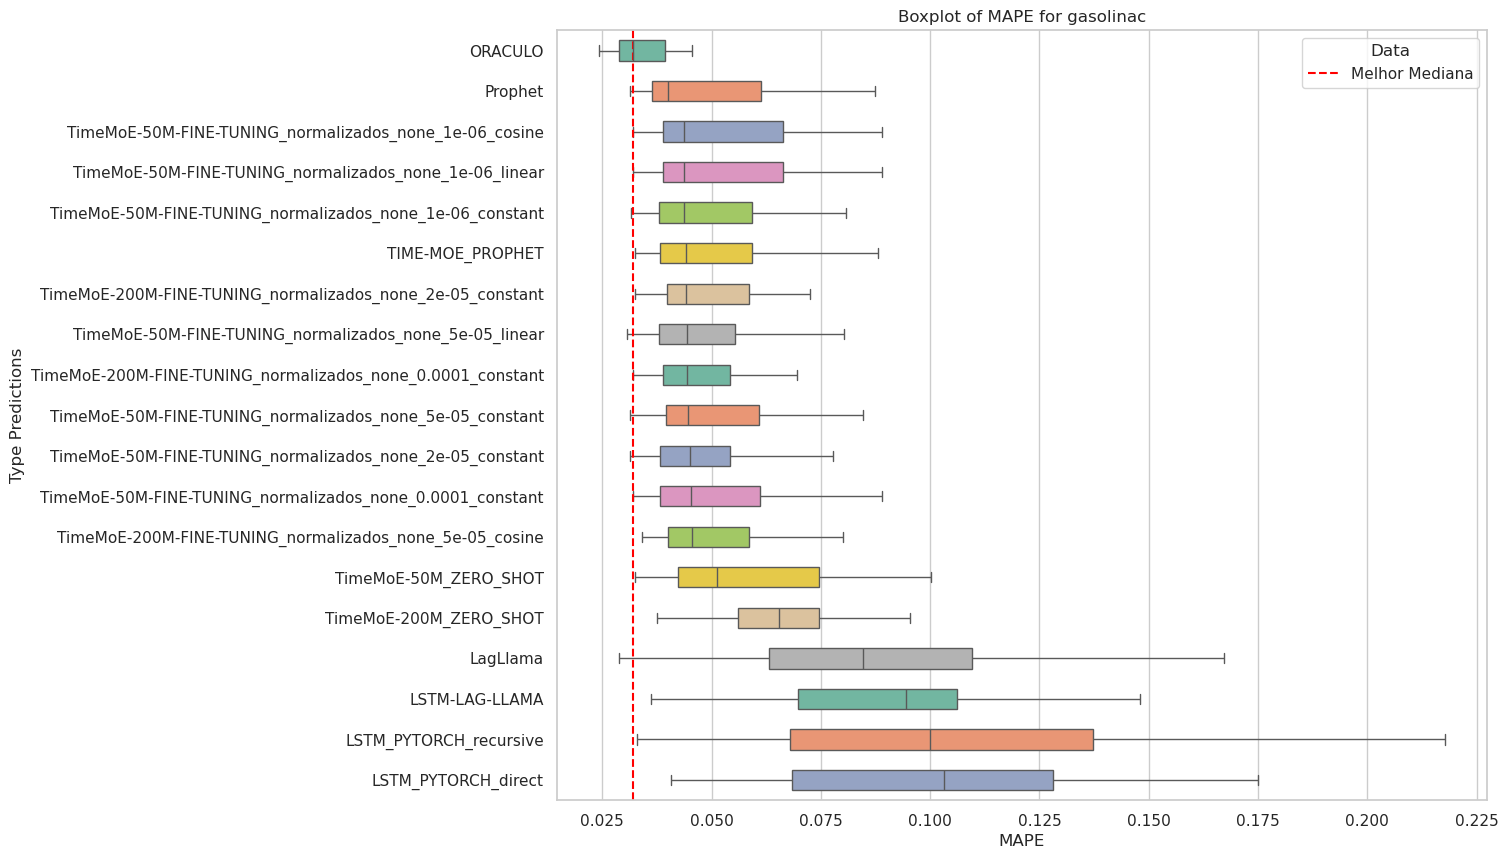

/tmp/ipykernel_2758138/1102054780.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y='TYPE_PREDICTIONS', x='MAPE', data=product_data,


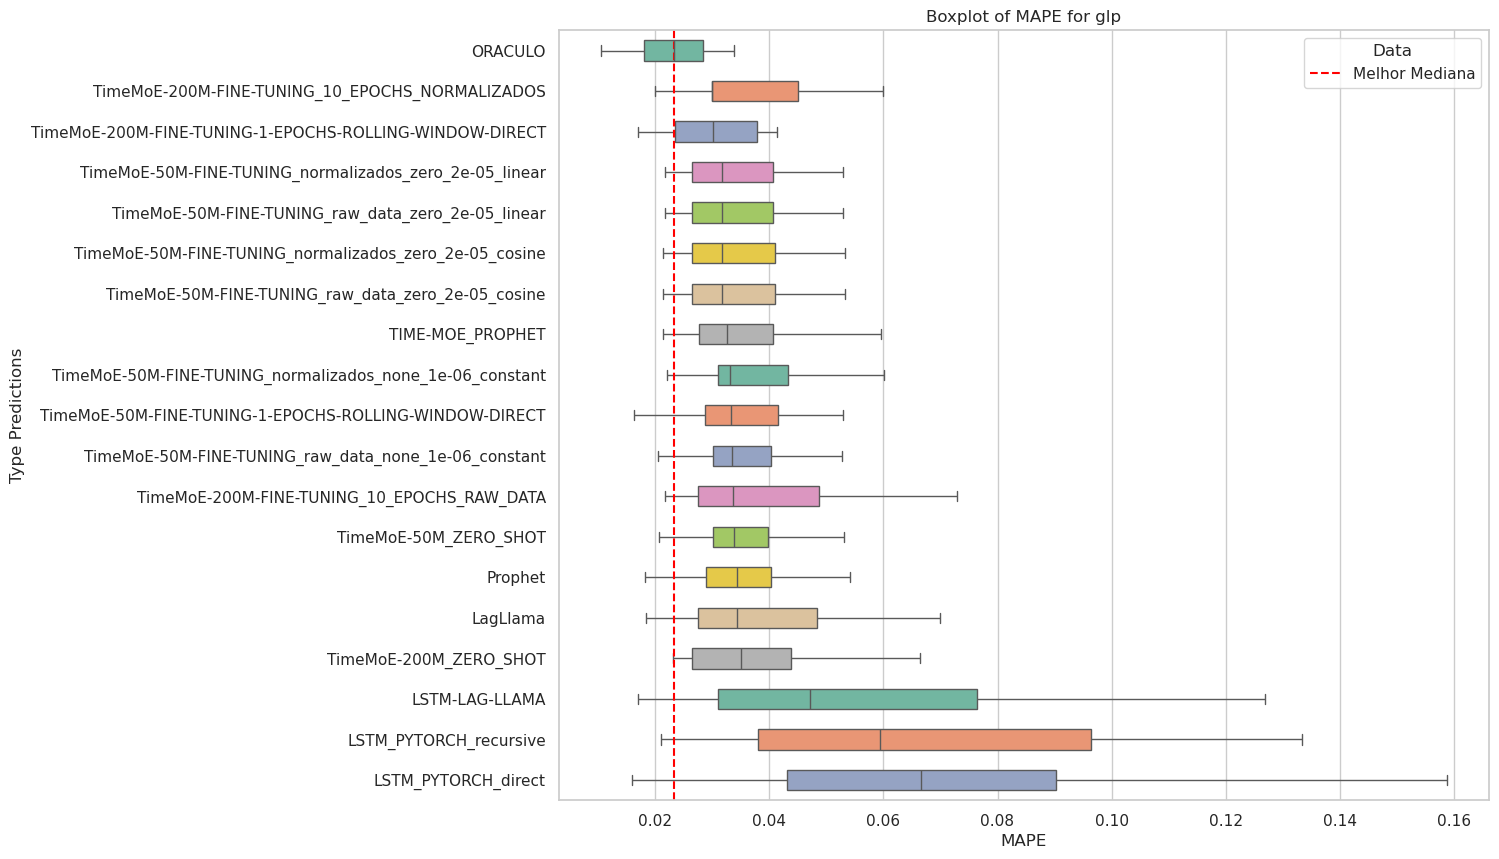

/tmp/ipykernel_2758138/1102054780.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y='TYPE_PREDICTIONS', x='MAPE', data=product_data,


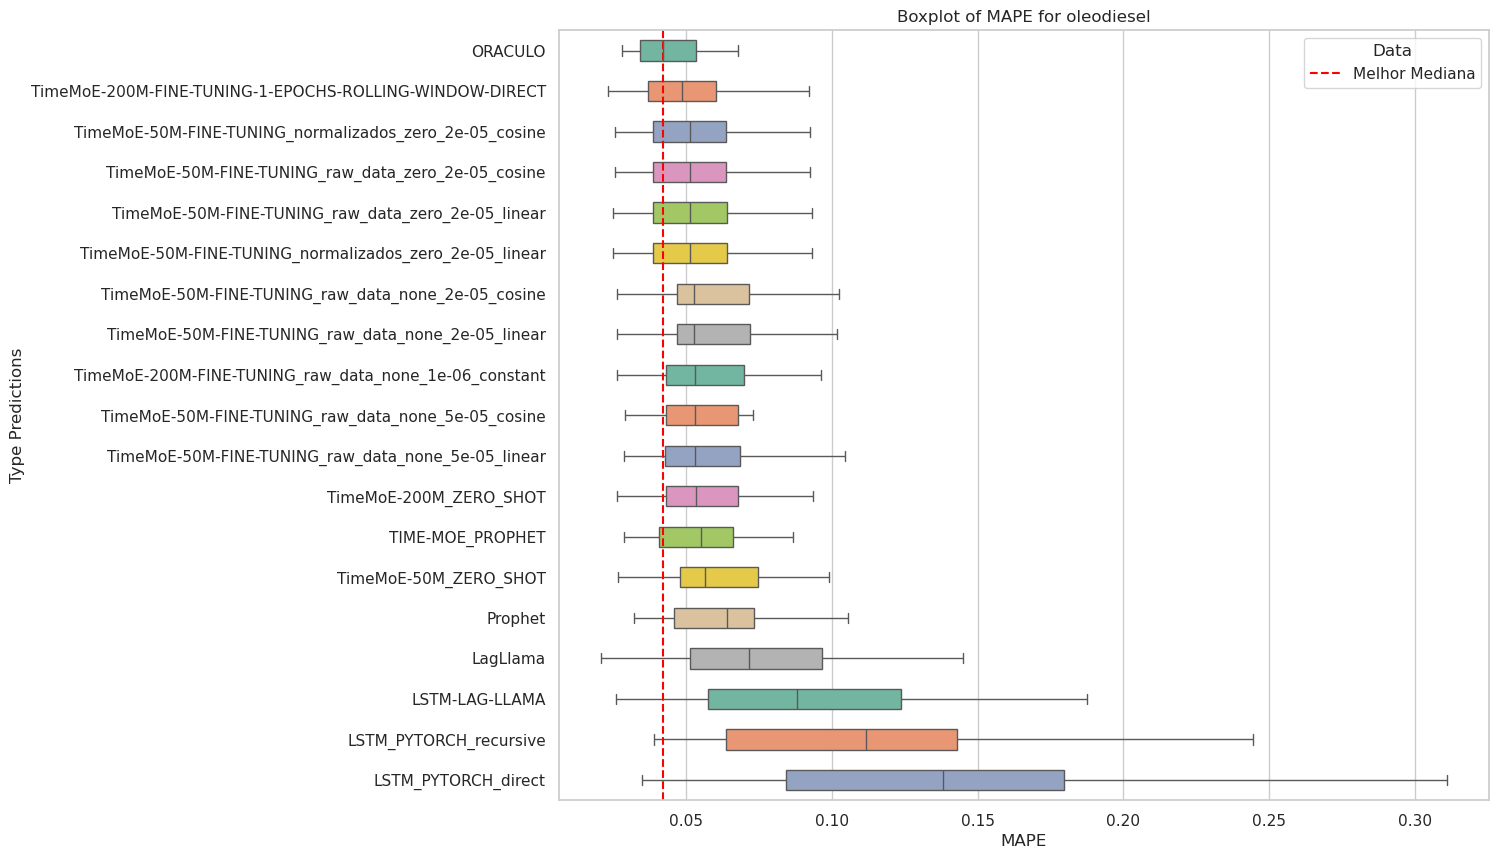

/tmp/ipykernel_2758138/1102054780.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y='TYPE_PREDICTIONS', x='MAPE', data=product_data,


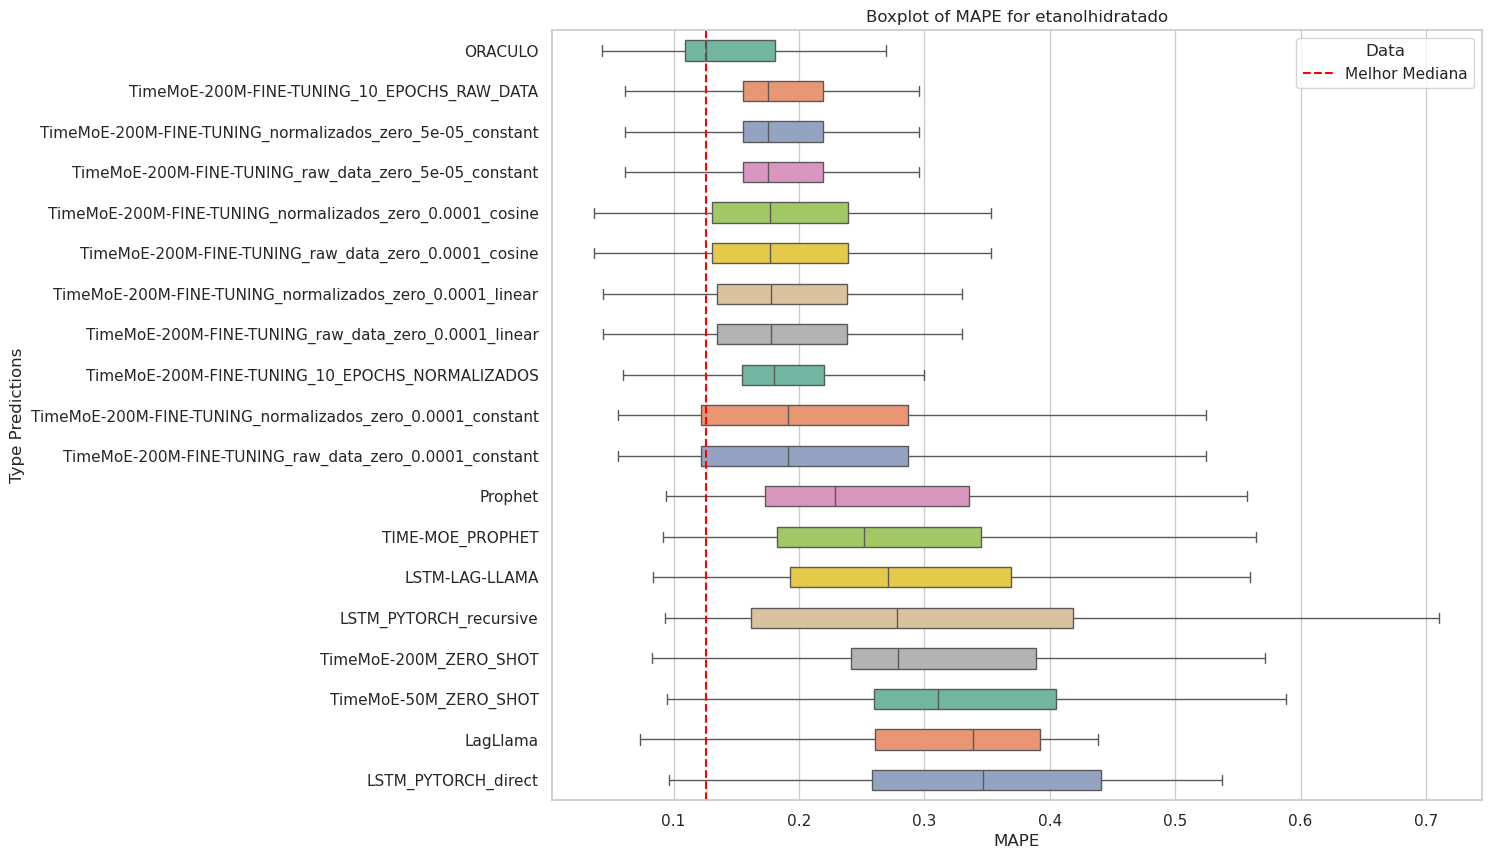

/tmp/ipykernel_2758138/1102054780.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y='TYPE_PREDICTIONS', x='MAPE', data=product_data,


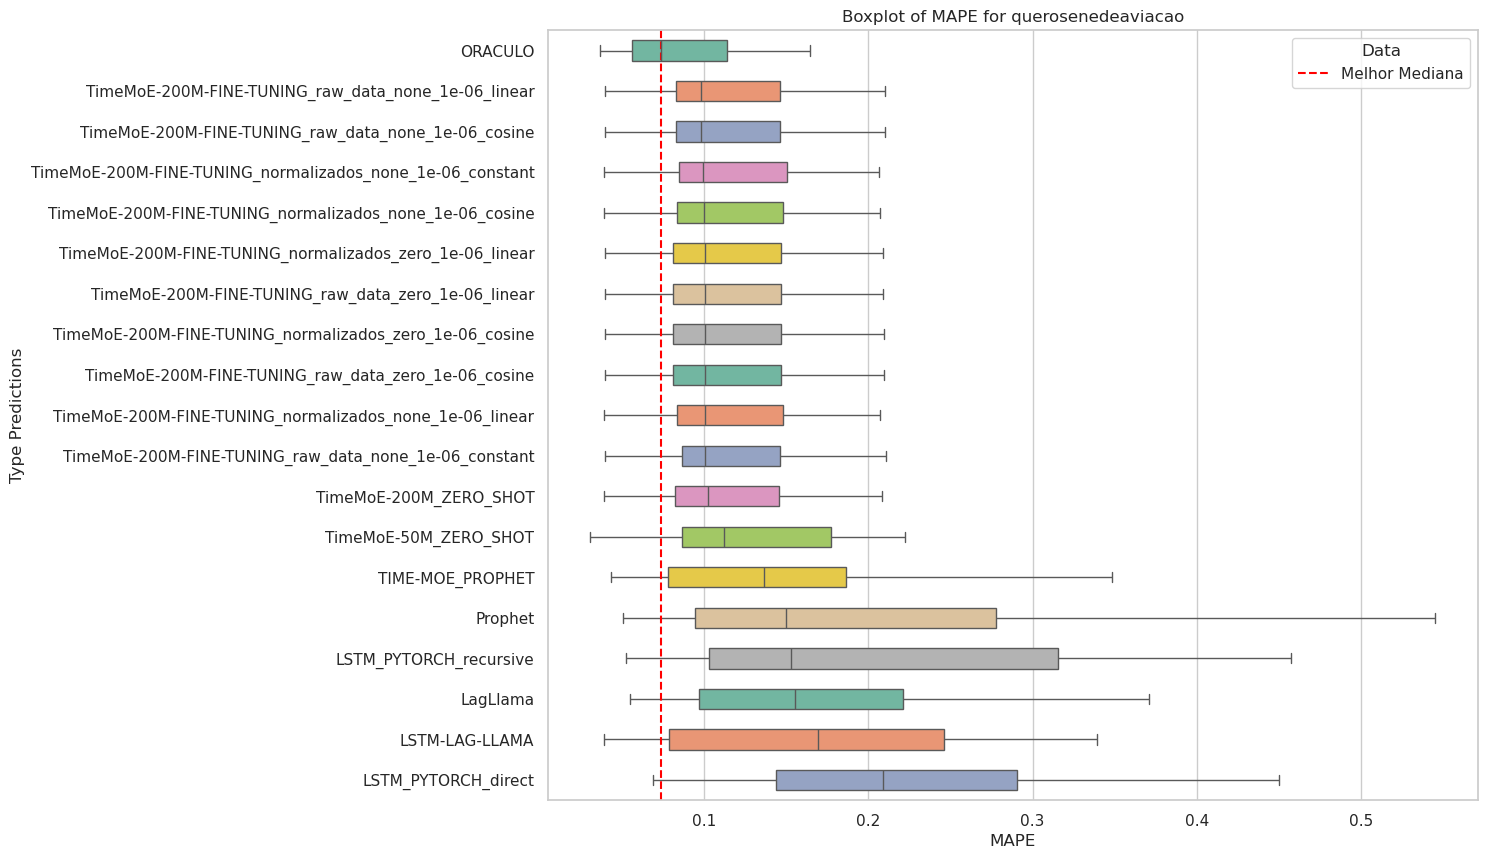

In [54]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Calcular a mediana de MAPE para cada combinação de PRODUCT e TYPE_PREDICTIONS
median_mape = df.groupby(['PRODUCT', 'TYPE_PREDICTIONS'])['MAPE'].median().reset_index()

# Para cada PRODUCT, criar uma lista de TYPE_PREDICTIONS ordenados pela mediana
order_dict = {}
best_median_dict = {}
for product in df['PRODUCT'].unique():
    product_median = median_mape[median_mape['PRODUCT'] == product].sort_values(by='MAPE')
    order_dict[product] = product_median['TYPE_PREDICTIONS'].tolist()
    best_median_dict[product] = product_median['MAPE'].min()  # Armazenar a melhor mediana

# Plotar boxplots para cada PRODUCT com a ordem correta e na orientação vertical
for product in df['PRODUCT'].unique():
    # Criar o boxplot vertical
    plt.figure(figsize=(12, 10))
    
    # Filtrar os dados para o PRODUCT atual
    product_data = df[df['PRODUCT'] == product]
    
    # Criar o boxplot
    sns.boxplot(y='TYPE_PREDICTIONS', x='MAPE', data=product_data, 
                order=order_dict[product], showfliers=False, 
                palette="Set2", 
                width=0.5)
    
    # Adicionar título e rótulos
    plt.title(f'Boxplot of MAPE for {product}')
    plt.ylabel('Type Predictions')
    plt.xlabel('MAPE')
    
    # Adicionar linha pontilhada vermelha na melhor mediana
    plt.axvline(x=best_median_dict[product], color='red', linestyle='--', label='Melhor Mediana')
    
    # Exibir o gráfico
    plt.legend(title='Data')
    plt.show()


### 5 Anos

/tmp/ipykernel_2758138/3576028983.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y='TYPE_PREDICTIONS', x='MAPE', data=product_data,


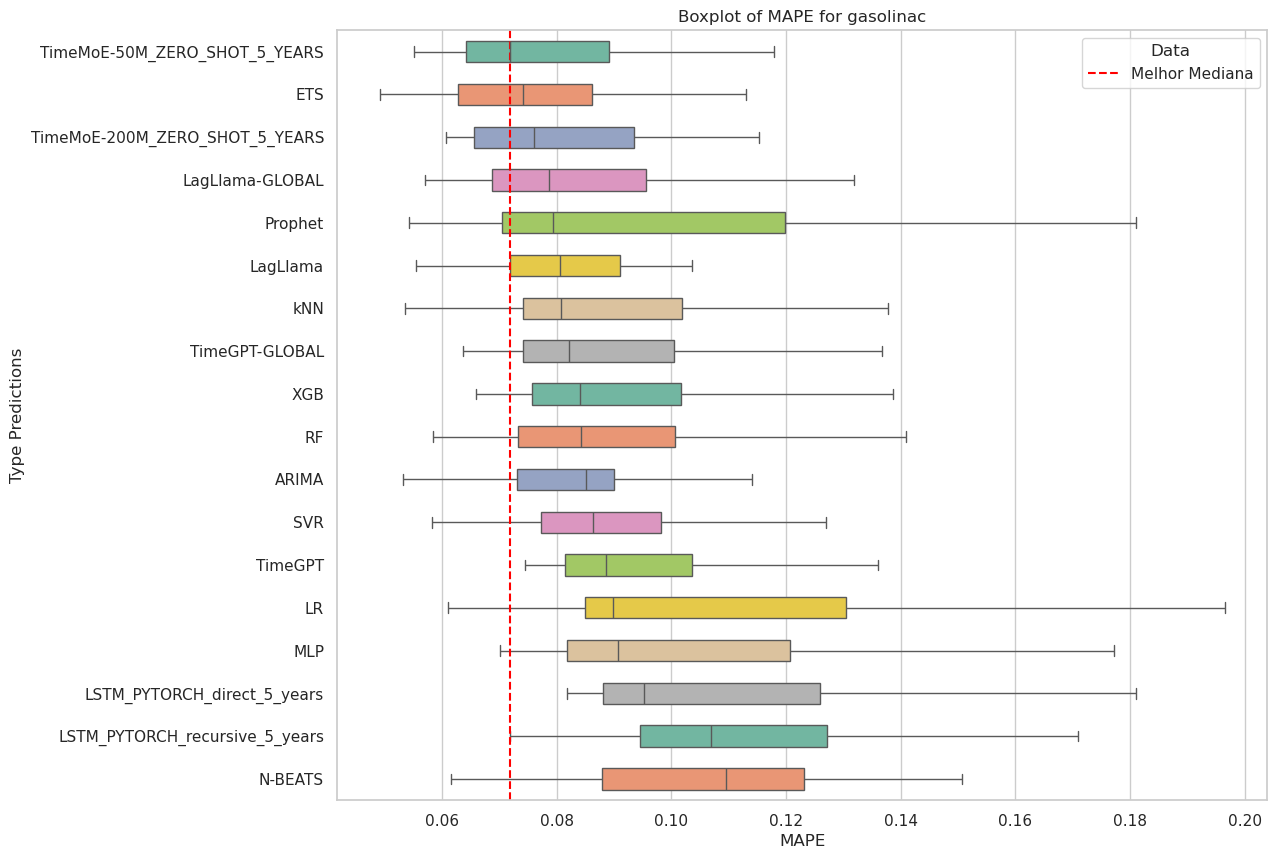

/tmp/ipykernel_2758138/3576028983.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y='TYPE_PREDICTIONS', x='MAPE', data=product_data,


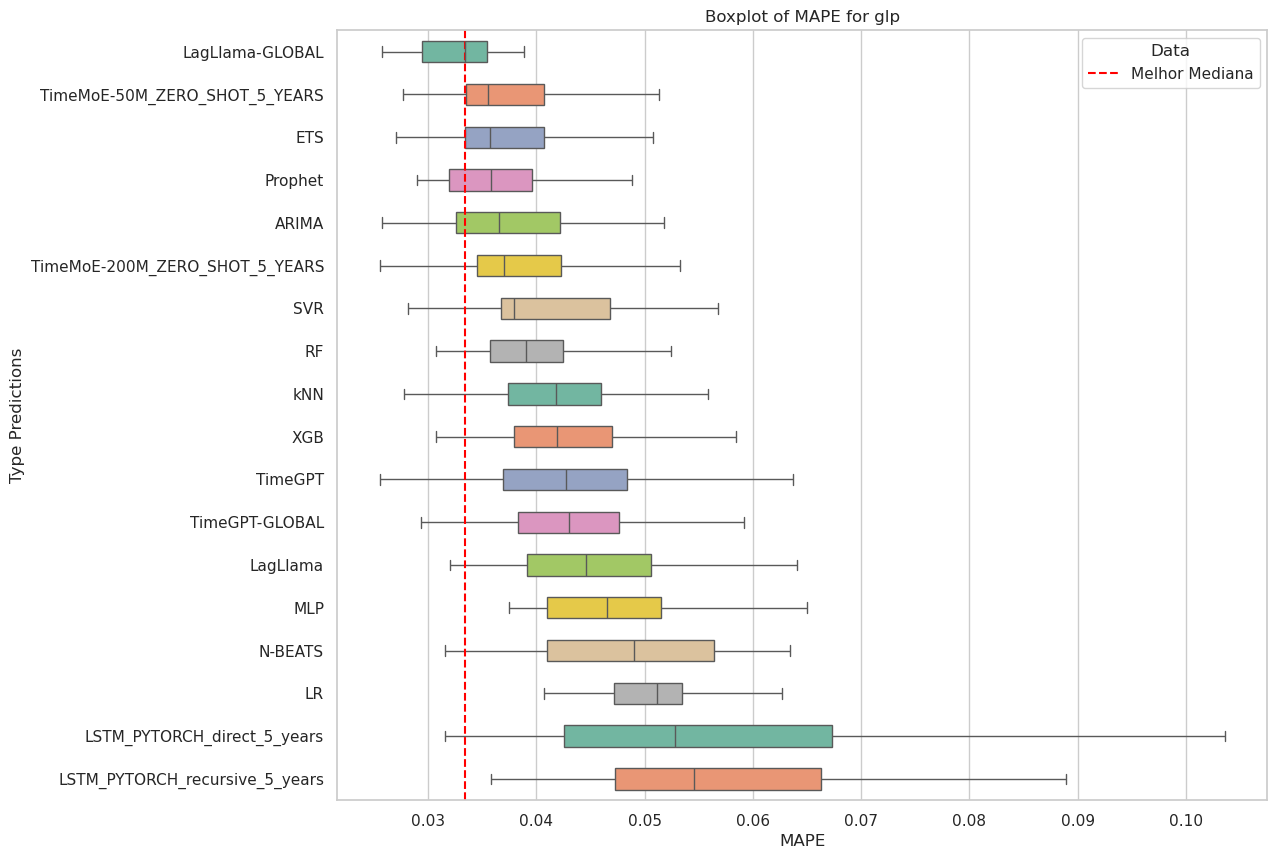

/tmp/ipykernel_2758138/3576028983.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y='TYPE_PREDICTIONS', x='MAPE', data=product_data,


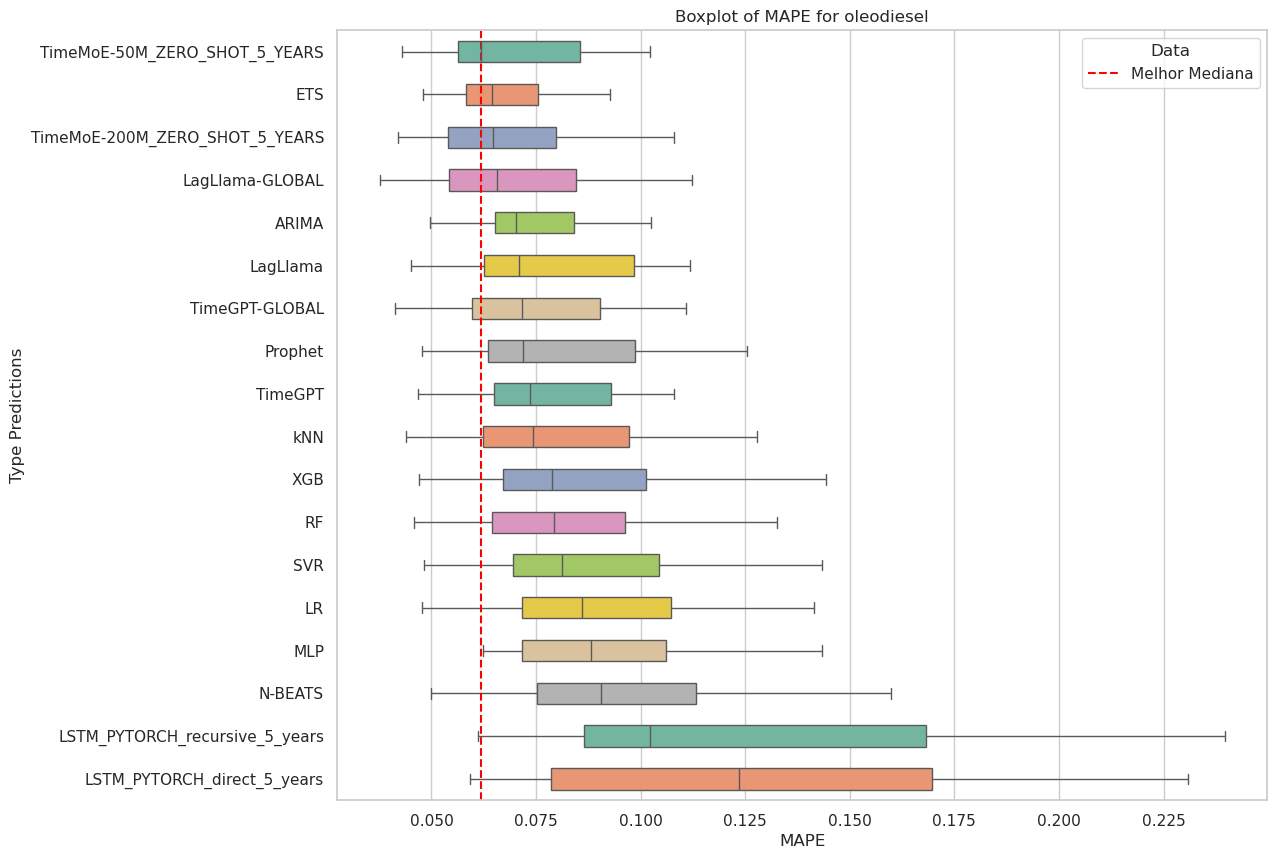

/tmp/ipykernel_2758138/3576028983.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y='TYPE_PREDICTIONS', x='MAPE', data=product_data,


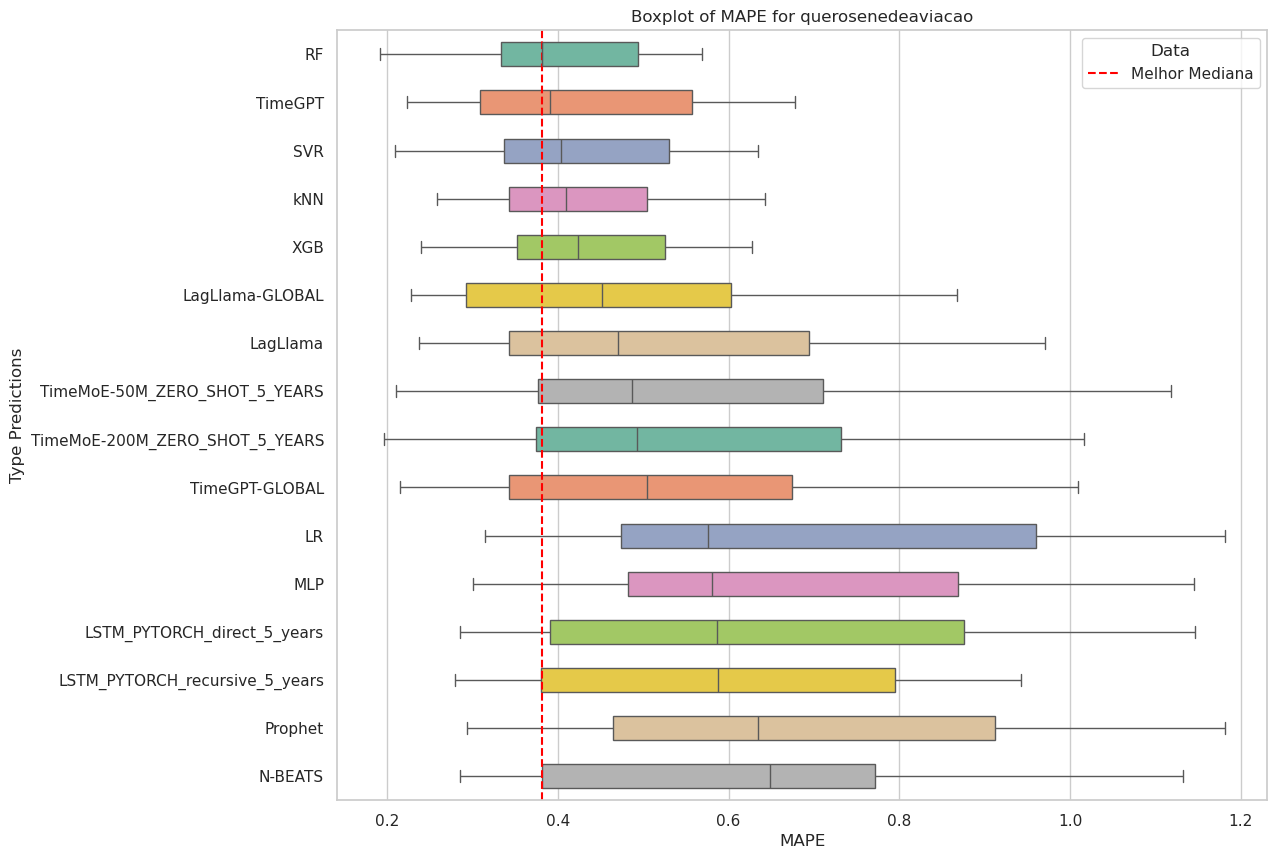

/tmp/ipykernel_2758138/3576028983.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y='TYPE_PREDICTIONS', x='MAPE', data=product_data,


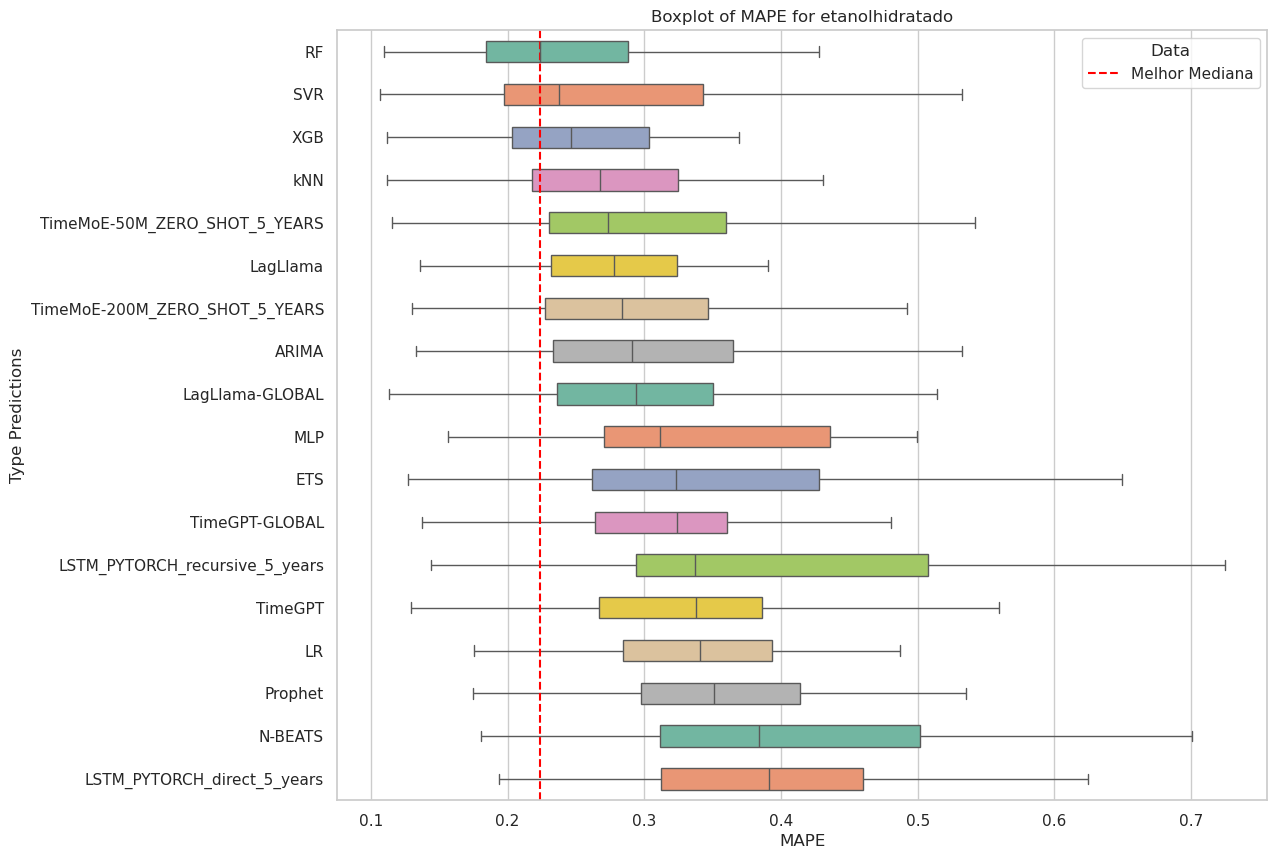

In [55]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Calcular a mediana de MAPE para cada combinação de PRODUCT e TYPE_PREDICTIONS
median_mape = df_5_years.groupby(['PRODUCT', 'TYPE_PREDICTIONS'])['MAPE'].median().reset_index()

# Para cada PRODUCT, criar uma lista de TYPE_PREDICTIONS ordenados pela mediana
order_dict = {}
best_median_dict = {}
for product in df_5_years['PRODUCT'].unique():
    product_median = median_mape[median_mape['PRODUCT'] == product].sort_values(by='MAPE')
    order_dict[product] = product_median['TYPE_PREDICTIONS'].tolist()
    best_median_dict[product] = product_median['MAPE'].min()  # Armazenar a melhor mediana

# Plotar boxplots para cada PRODUCT com a ordem correta e na orientação vertical
for product in df_5_years['PRODUCT'].unique():
    # Criar o boxplot vertical
    plt.figure(figsize=(12, 10))
    
    # Filtrar os dados para o PRODUCT atual
    product_data = df_5_years[df_5_years['PRODUCT'] == product]
    
    # Criar o boxplot
    sns.boxplot(y='TYPE_PREDICTIONS', x='MAPE', data=product_data, 
                order=order_dict[product], showfliers=False, 
                palette="Set2", 
                width=0.5)
    
    # Adicionar título e rótulos
    plt.title(f'Boxplot of MAPE for {product}')
    plt.ylabel('Type Predictions')
    plt.xlabel('MAPE')
    
    # Adicionar linha pontilhada vermelha na melhor mediana
    plt.axvline(x=best_median_dict[product], color='red', linestyle='--', label='Melhor Mediana')
    
    # Exibir o gráfico
    plt.legend(title='Data')
    plt.show()


### MASE

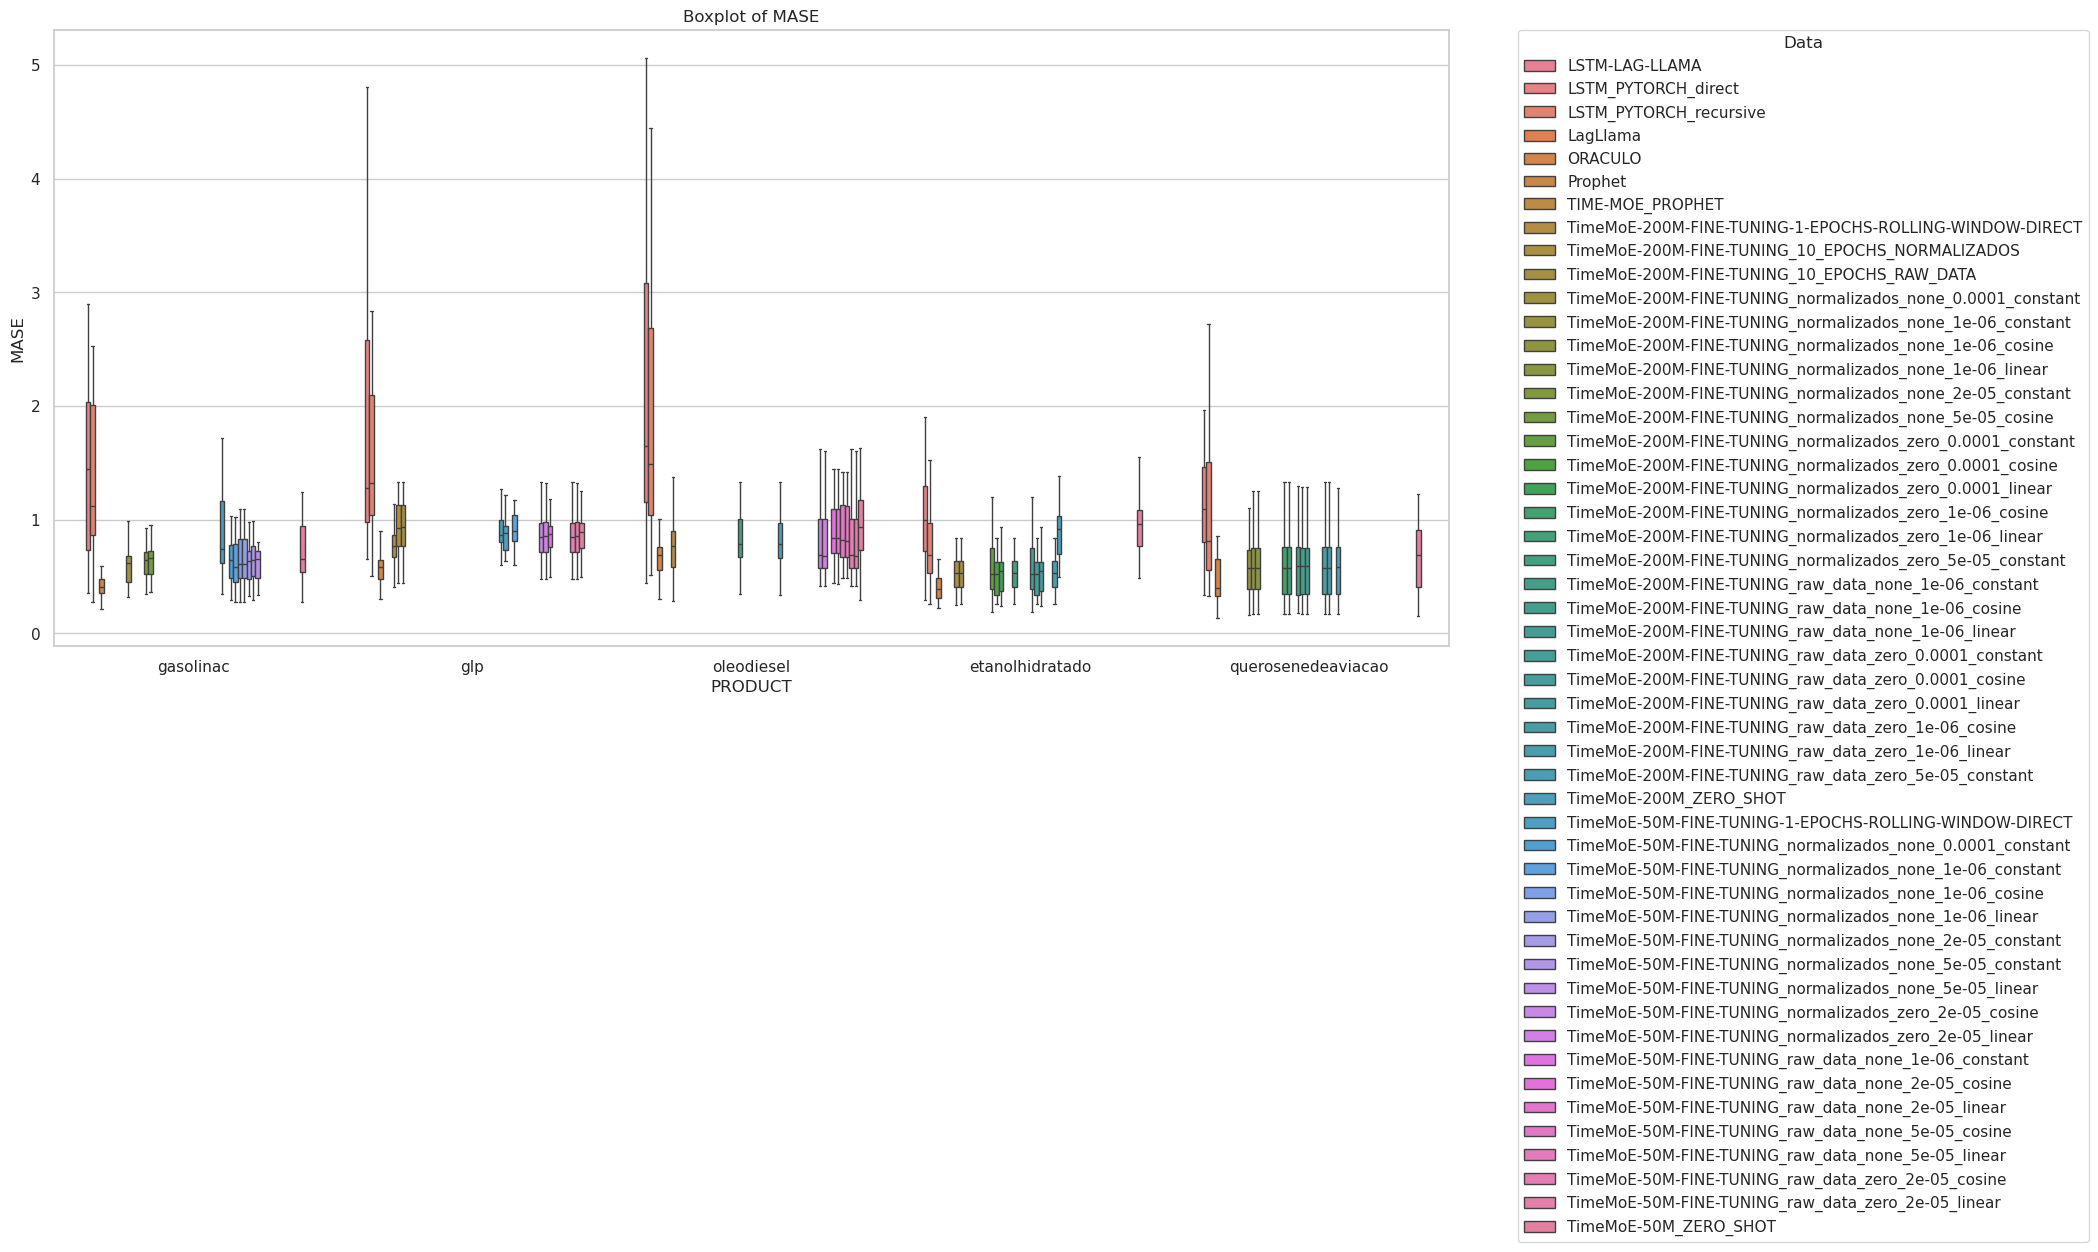

In [56]:
# Setting the aesthetics for the plot
sns.set(style="whitegrid")
 
# Creating the boxplot
plt.figure(figsize=(18, 8))

sorted_hue = sorted(df['TYPE_PREDICTIONS'].unique())

# Generating the boxplot with ordered legends
boxplot = sns.boxplot(x='PRODUCT', y='MASE', hue='TYPE_PREDICTIONS', data=df, showfliers=False, hue_order=sorted_hue)
boxplot.set_title('Boxplot of MASE')
 
# Positioning the legend on the right side, outside the plot area
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., title='Data')

plt.show()


### PBE

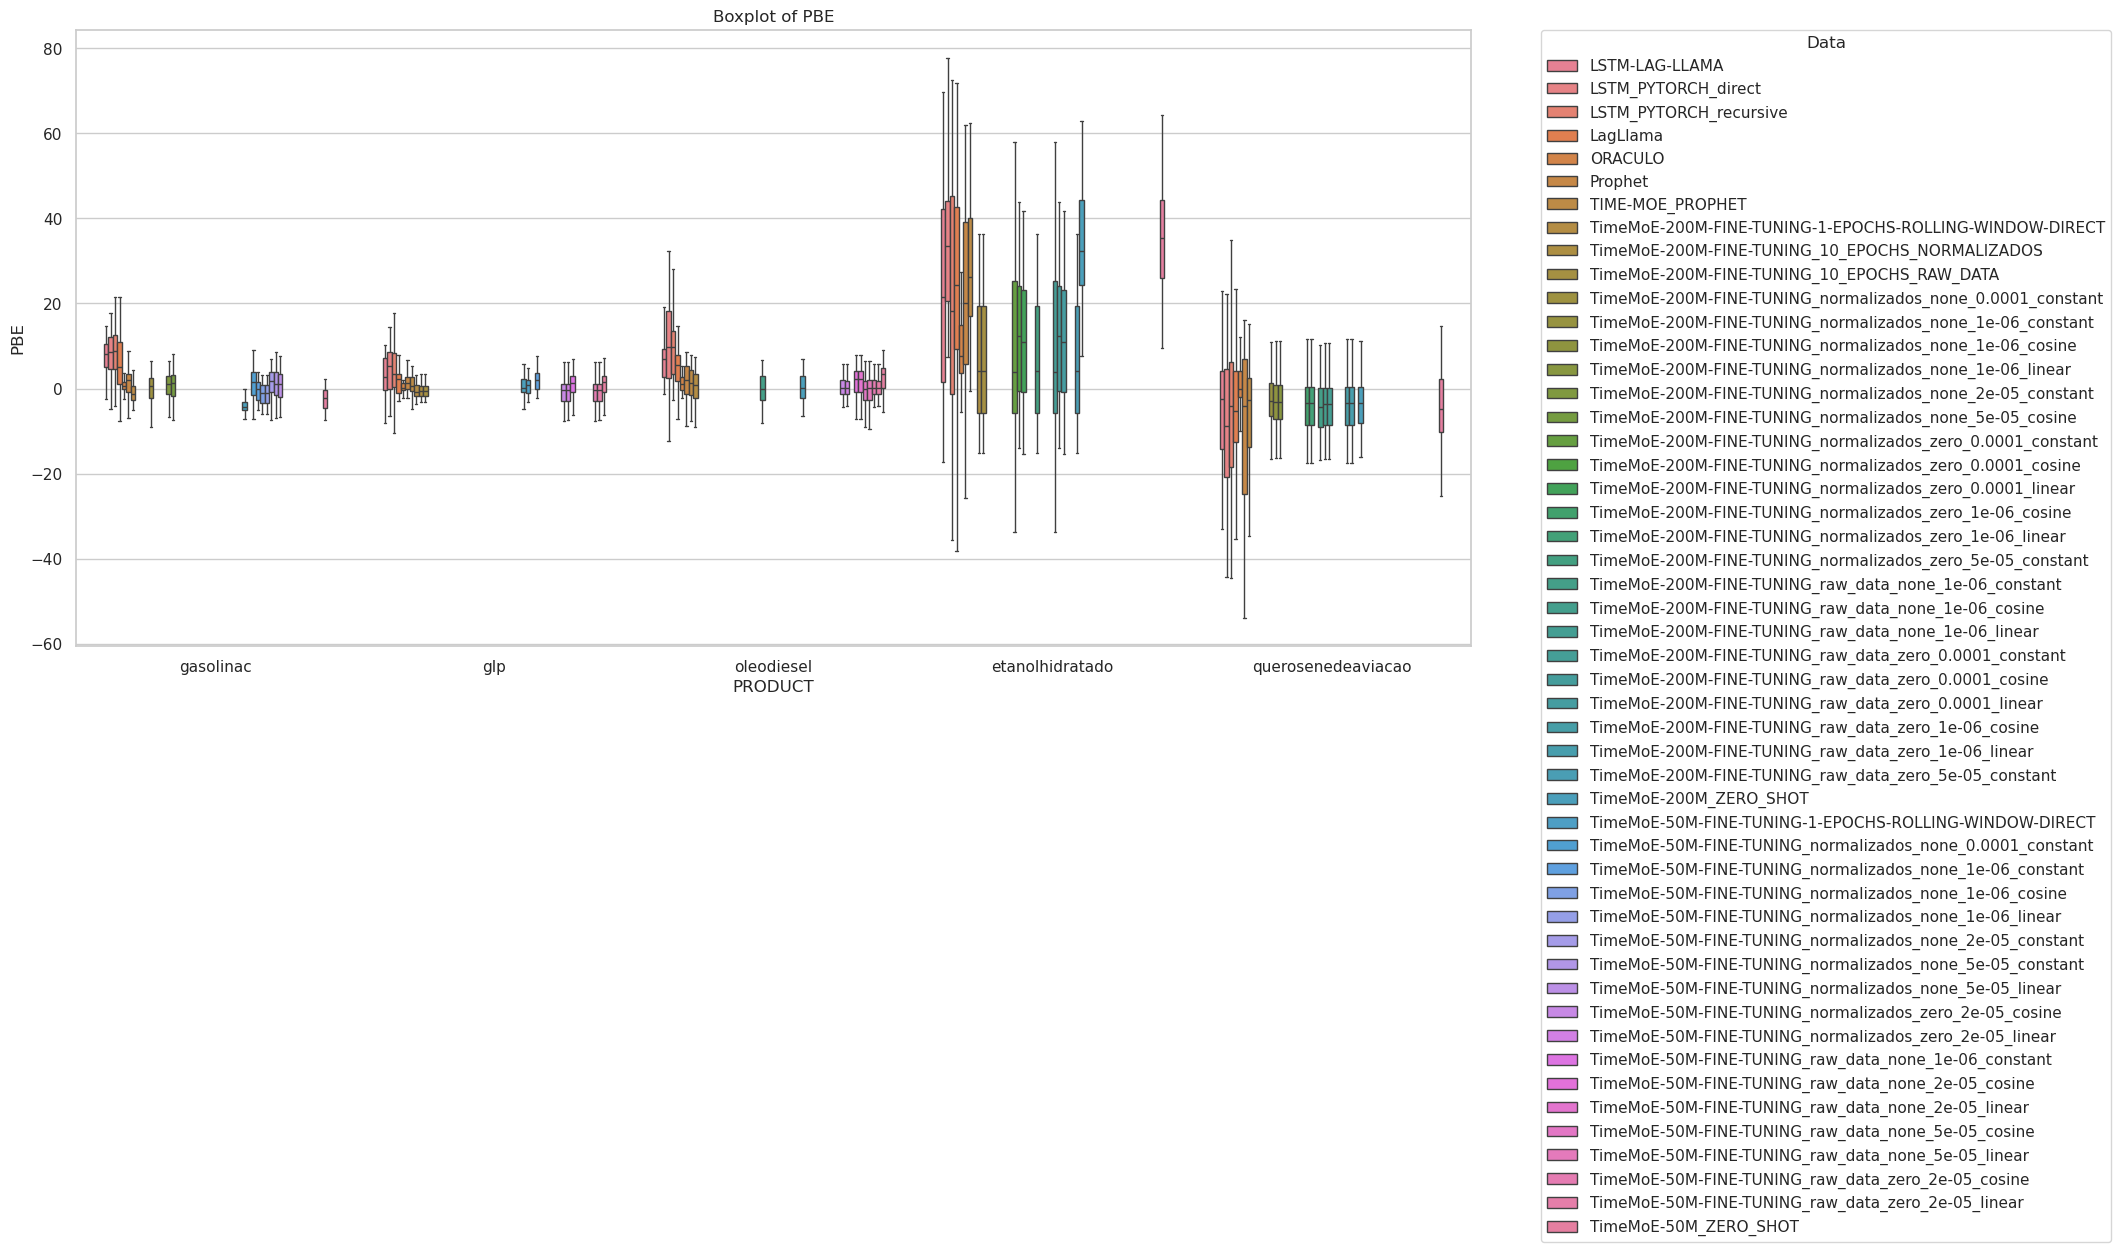

In [57]:
# Setting the aesthetics for the plot
sns.set(style="whitegrid")
 
# Creating the boxplot
plt.figure(figsize=(18, 8))

sorted_hue = sorted(df['TYPE_PREDICTIONS'].unique())

# Generating the boxplot with ordered legends
boxplot = sns.boxplot(x='PRODUCT', y='PBE', hue='TYPE_PREDICTIONS', data=df, showfliers=False, hue_order=sorted_hue)
boxplot.set_title('Boxplot of PBE')
 
# Positioning the legend on the right side, outside the plot area
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., title='Data')

plt.show()


### POCID

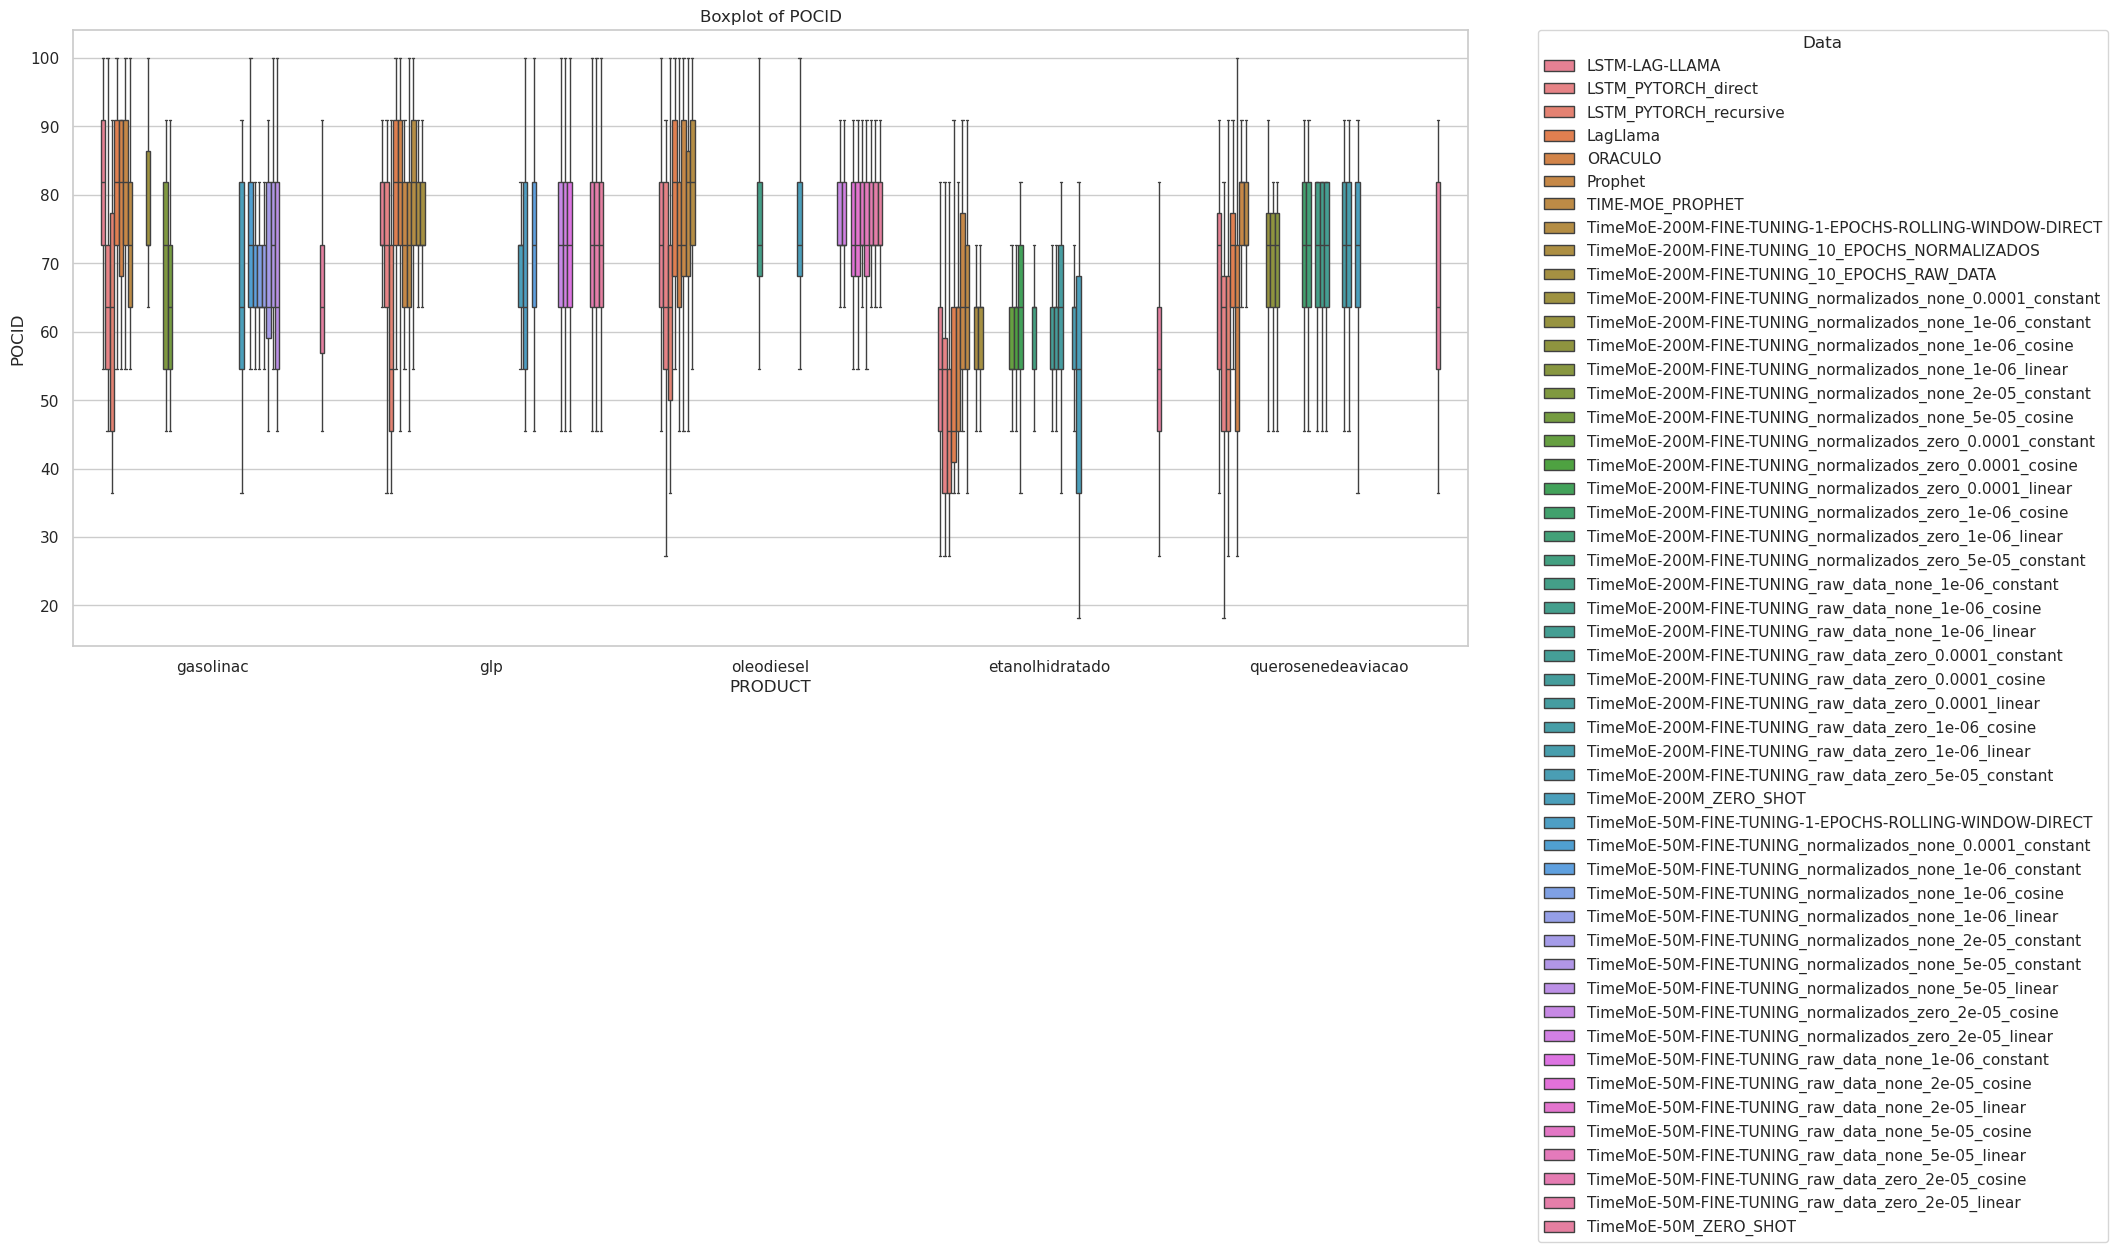

In [58]:
# Setting the aesthetics for the plot
sns.set(style="whitegrid")
 
# Creating the boxplot
plt.figure(figsize=(18, 8))

sorted_hue = sorted(df['TYPE_PREDICTIONS'].unique())

# Generating the boxplot with ordered legends
boxplot = sns.boxplot(x='PRODUCT', y='POCID', hue='TYPE_PREDICTIONS', data=df, showfliers=False, hue_order=sorted_hue)
boxplot.set_title('Boxplot of POCID')
 
# Positioning the legend on the right side, outside the plot area
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., title='Data')

plt.show()
